### **Principales couches PyTorch**

| Type de couche         | Module PyTorch               | Description |
|------------------------|------------------------------|-------------|
| Linéaire (dense)       | `nn.Linear(in_features, out_features)` | Couche fully-connected |
| Convolution 2D         | `nn.Conv2d(in_channels, out_channels, kernel_size)` | Pour images |
| Batch Normalization 1D | `nn.BatchNorm1d(num_features)`| Normalise sur la batch |
| Batch Normalization 2D | `nn.BatchNorm2d(num_features)`| Spécifique à images |
| Dropout                | `nn.Dropout(p=0.5)`           | Désactive aléatoirement des neurones |
| Max Pooling 2D         | `nn.MaxPool2d(kernel_size)`   | Réduction de taille par max |
| Avg Pooling 2D         | `nn.AvgPool2d(kernel_size)`   | Réduction de taille par moyenne |
| Flatten                | `nn.Flatten()`                | Aplatit les dimensions |
| Embedding              | `nn.Embedding(num_embeddings, embedding_dim)` | Représentation dense pour tokens |


In [ ]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

#### **Initialisation**
---

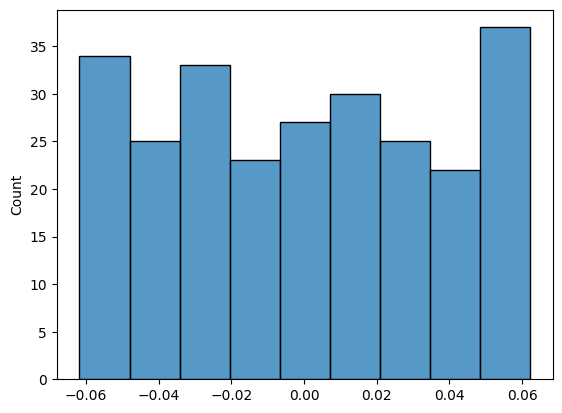

In [51]:
## Kaiiming init (default)
input_size = 256
bound = (1 / input_size)**0.5
x = torch.empty(input_size).uniform_(-bound, bound)

sns.histplot(x)
plt.show()

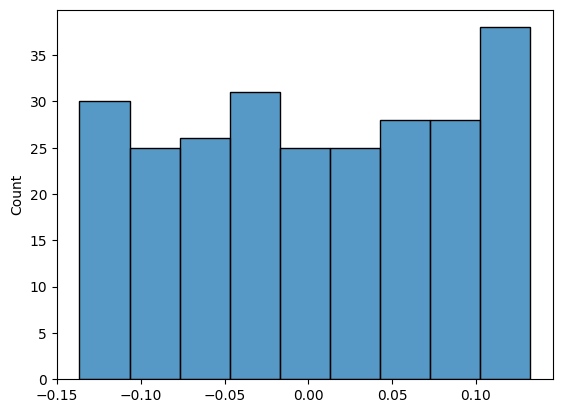

In [52]:
## Xavier init
input_size = 256
output_size = 64

bound = (6 / (input_size + output_size))**0.5
x = torch.empty(input_size).uniform_(-bound, bound)

sns.histplot(x)
plt.show()

#### **Linear layer**
---

In [63]:
dense_layer = nn.Linear(256, 64)

for param in dense_layer.parameters():
    print(param.shape)

torch.Size([64, 256])
torch.Size([64])


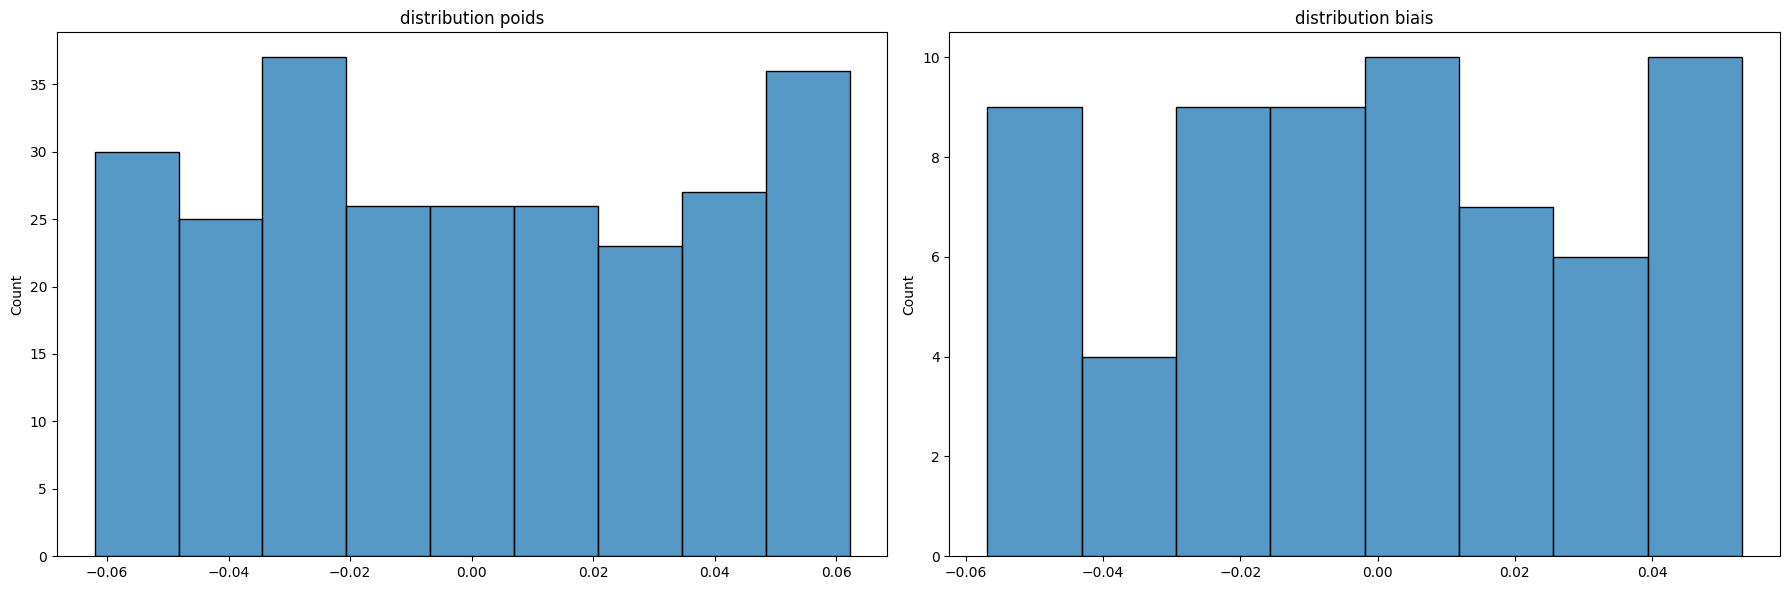

In [64]:
x = torch.randn(256)
y = dense_layer(x)

plt.figure(figsize=(18, 6))

plt.subplot(121)
sns.histplot(dense_layer.weight[0].detach().numpy())
plt.title("distribution poids")

plt.subplot(122)
sns.histplot(dense_layer.bias.detach().numpy())
plt.title("distribution biais")

plt.tight_layout()
plt.show()

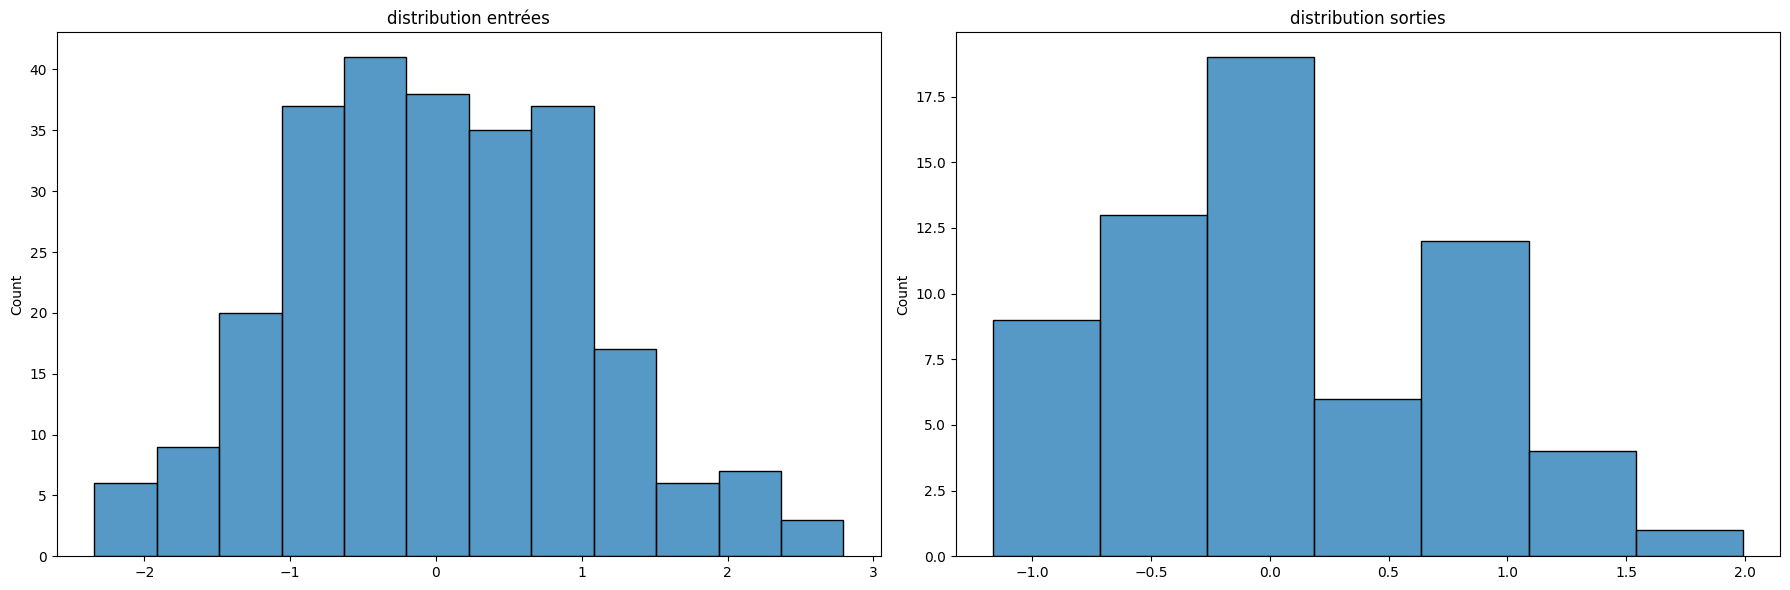

In [65]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
sns.histplot(x.detach().numpy())
plt.title("distribution entrées")

plt.subplot(122)
sns.histplot(y.detach().numpy())
plt.title("distribution sorties")

plt.tight_layout()
plt.show()

In [71]:
weight = dense_layer.weight
bias = dense_layer.bias

y_manual = torch.mm(x.unsqueeze(0), weight.T) + bias
print(y - y_manual)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<SubBackward0>)


#### **Conv2d**
---

In [77]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, stride=1, padding=1)

for param in conv_layer.parameters():
    print(param.shape, param)

torch.Size([2, 3, 3, 3]) Parameter containing:
tensor([[[[ 0.0510, -0.1101,  0.1341],
          [-0.1127, -0.0306, -0.0654],
          [ 0.0937, -0.0789,  0.1163]],

         [[ 0.0606,  0.1162,  0.0040],
          [ 0.1519,  0.1371, -0.0142],
          [-0.0907, -0.0289, -0.1060]],

         [[ 0.0021, -0.0211, -0.1033],
          [ 0.1529,  0.0319, -0.0985],
          [-0.1492, -0.0858, -0.1243]]],


        [[[ 0.1622,  0.1301,  0.1613],
          [-0.0445,  0.0101,  0.1169],
          [-0.0130, -0.1259, -0.1106]],

         [[ 0.0792,  0.1096, -0.0503],
          [-0.0839,  0.0906,  0.0154],
          [ 0.0411,  0.1092,  0.0231]],

         [[ 0.0176,  0.1367, -0.0711],
          [-0.1411, -0.1069, -0.1538],
          [-0.1794,  0.0509,  0.1006]]]], requires_grad=True)
torch.Size([2]) Parameter containing:
tensor([-0.0953,  0.0727], requires_grad=True)


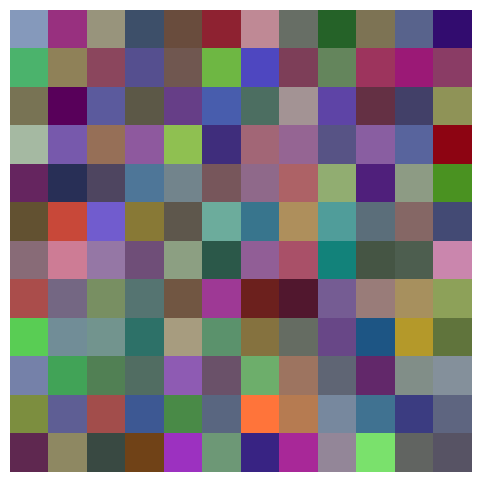

In [90]:
img_rgb = torch.stack([
        torch.randn(12, 12),
        torch.randn(12, 12),
        torch.randn(12, 12)
    ], 2)
img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())

plt.figure(figsize=(8, 6))

plt.imshow(img_rgb.numpy())
plt.axis('off')

plt.show()

In [96]:
print(img_rgb.permute(2, 0, 1).shape)

torch.Size([3, 12, 12])


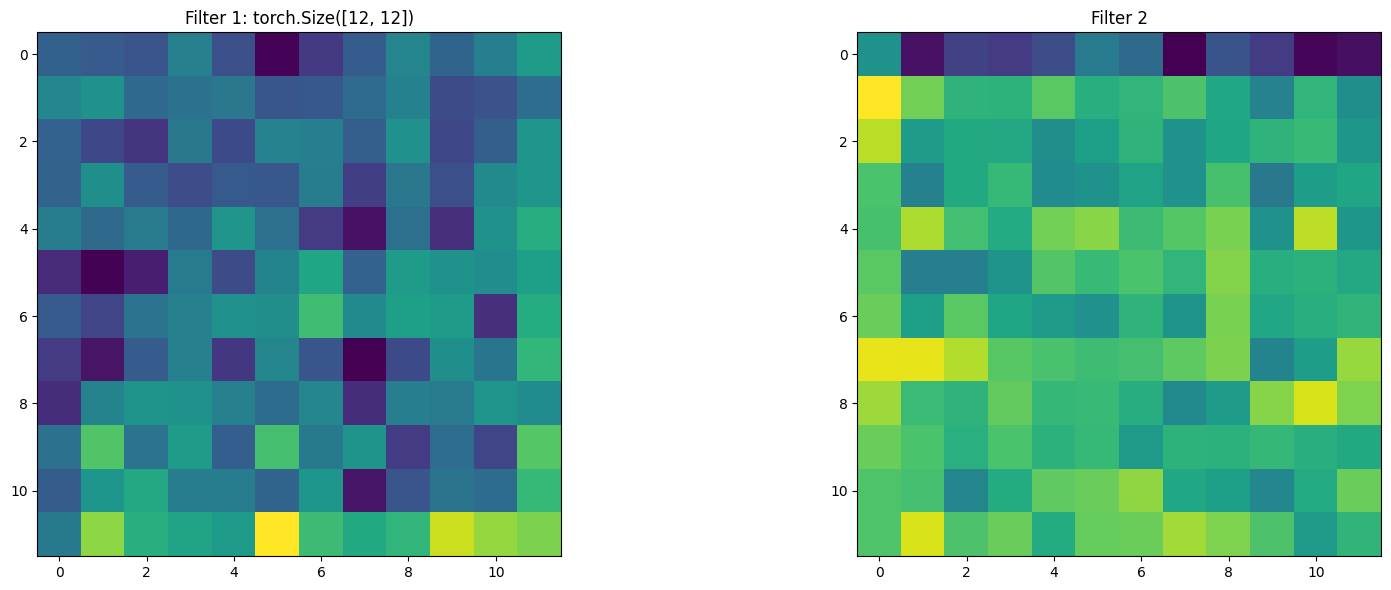

In [101]:
filters = conv_layer(img_rgb.permute(2, 0, 1))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.imshow(filters[0].detach().numpy())
plt.title(f"Filter 1: {filters[0].shape}")

plt.subplot(122)
plt.imshow(filters[1].detach().numpy())
plt.title(f"Filter 2")

plt.tight_layout()
plt.show()

In [ ]:
## manuellement
def manual_conv2d(input_tensor, weight, bias, stride=1, padding=1):
    _, H_in, L_in = input_tensor.shape
    C_out, _, K, _ = weight.shape

    input_padded = F.pad(input_tensor, (padding, padding, padding, padding))

    H_out = (H_in + 2*padding - K) // stride + 1
    W_out = (L_in + 2*padding - K) // stride + 1

    output = torch.zeros((C_out, H_out, W_out))

    for out_c in range(C_out): # TODO: vecctorisation
        for i in range(H_out):
            for j in range(W_out):
                input_part = input_padded[:, i:i+K, j:j+K]
                
                val = (input_part * weight[out_c]).sum()
                val += bias[out_c]
                output[out_c, i, j] = val
    return output

weight = conv_layer.weight.data
bias = conv_layer.bias.data

input_tensor = img_rgb.permute(2, 0, 1)

output_manual = manual_conv2d(input_tensor, weight, bias)

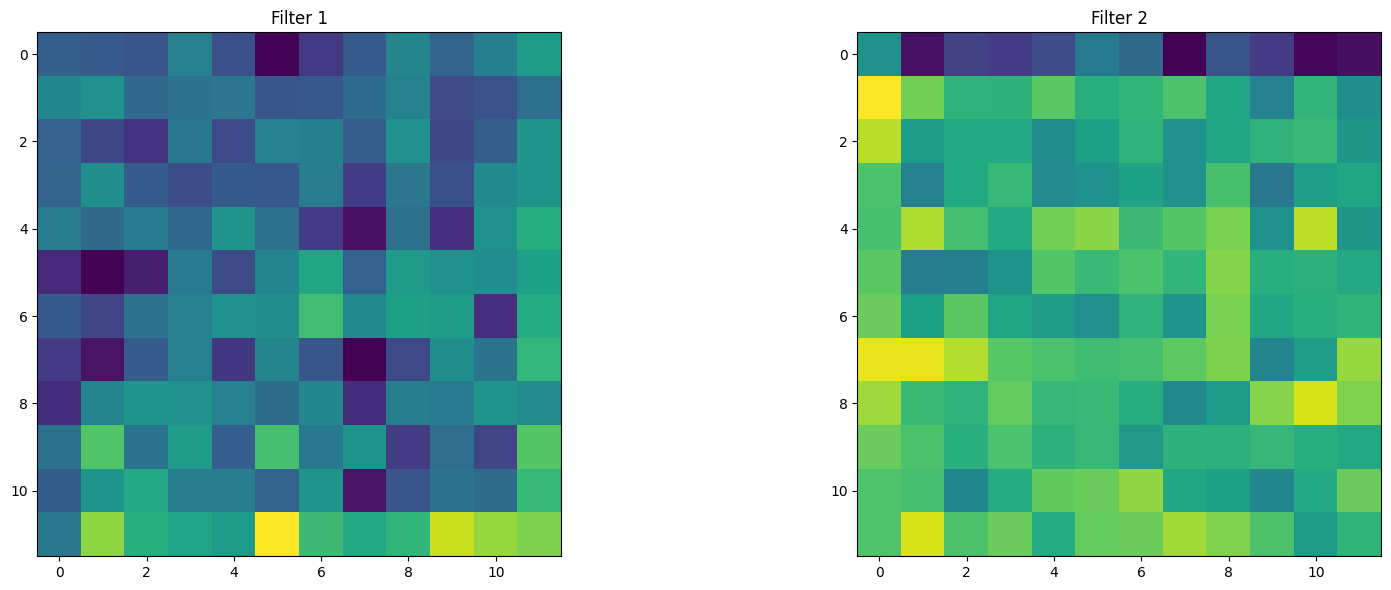

In [113]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.imshow(output_manual[0].detach().numpy())
plt.title(f"Filter 1")

plt.subplot(122)
plt.imshow(output_manual[1].detach().numpy())
plt.title(f"Filter 2")

plt.tight_layout()
plt.show()

#### **BatchNorm**
---

In [ ]:
## 1D

in_size = 1000
x = (torch.rand(2, in_size, 2) * 42)

layer_norm1d = nn.BatchNorm1d(in_size) # normalisation par var sur le batch / par échantillon avec layerNorm
y = layer_norm1d(x)

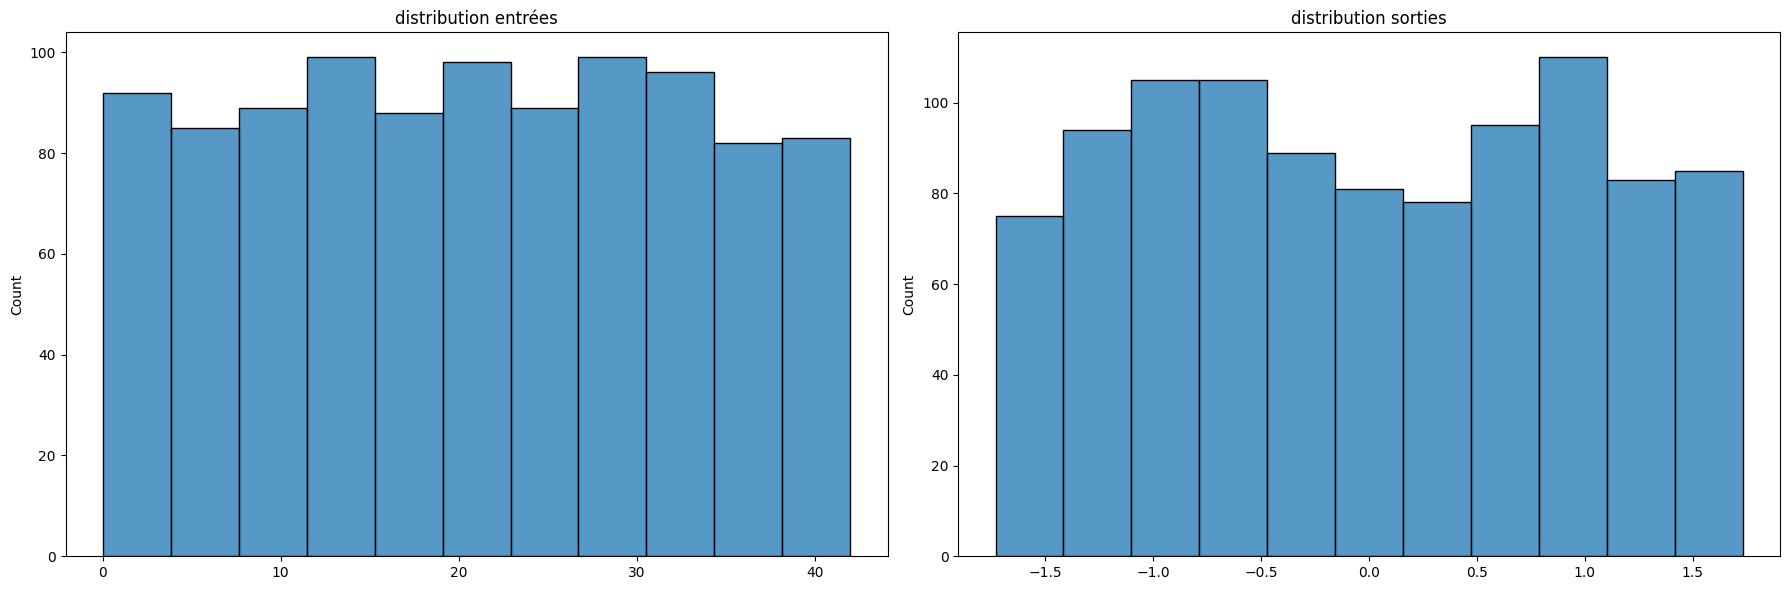

In [139]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
sns.histplot(x[1, :, 0].detach().numpy())
plt.title("distribution entrées")

plt.subplot(122)
sns.histplot(y[1, :, 0].detach().numpy())
plt.title("distribution sorties")

plt.tight_layout()
plt.show()

In [141]:
## 2D

C_size = 3
x = (torch.rand(2, C_size, 12, 12) * 42)

layer_norm2d = nn.BatchNorm2d(C_size) # normalisation par var sur le batch
y = layer_norm2d(x)

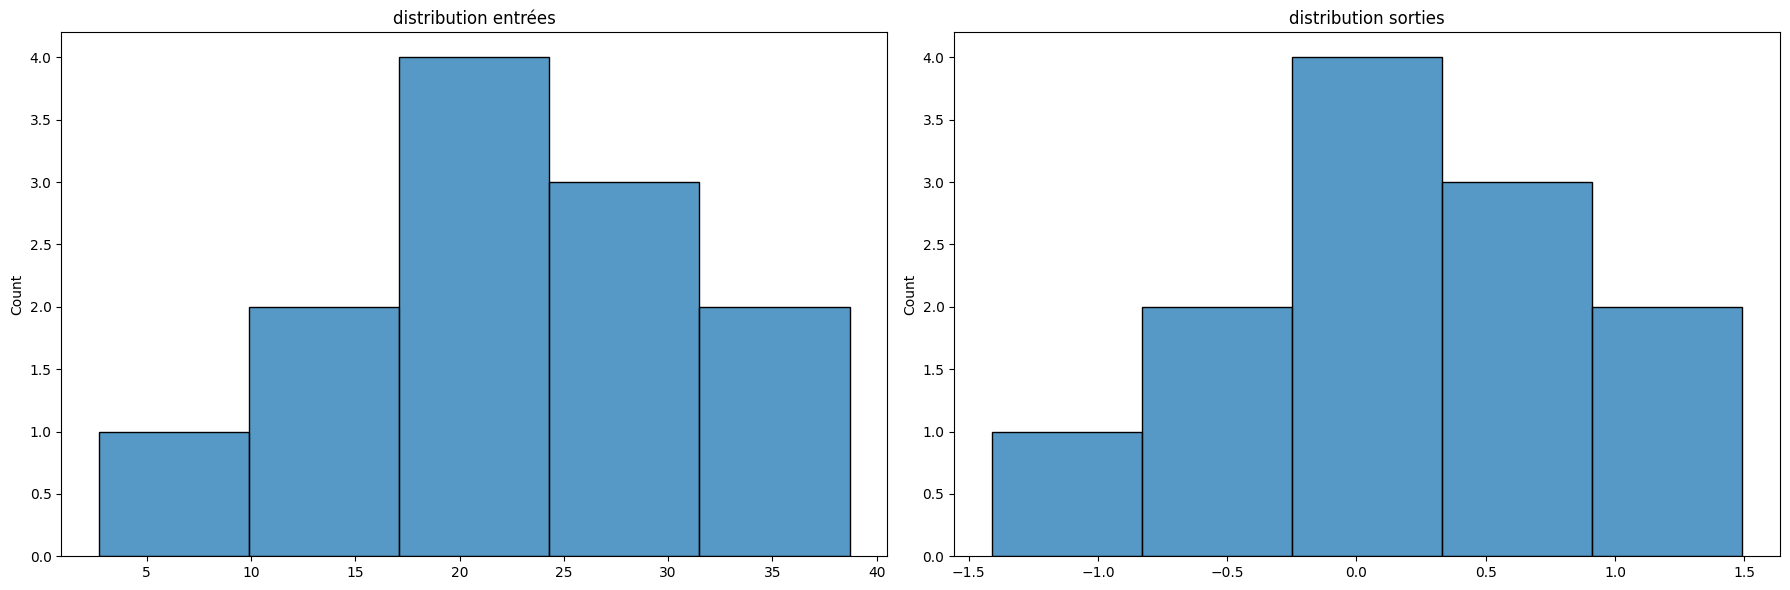

In [143]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
sns.histplot(x[0, 0, :, 0].detach().numpy())
plt.title("distribution entrées")

plt.subplot(122)
sns.histplot(y[0, 0, :, 0].detach().numpy())
plt.title("distribution sorties")

plt.tight_layout()
plt.show()

#### **Dropout**
---

In [169]:
x = torch.rand(1000, 1) * 5

drop_layer_s = nn.Dropout(0.25)
drop_layer_m = nn.Dropout(0.5)
drop_layer_l = nn.Dropout(0.75)

y_s, y_m, y_l = drop_layer_s(x), drop_layer_m(x), drop_layer_l(x)

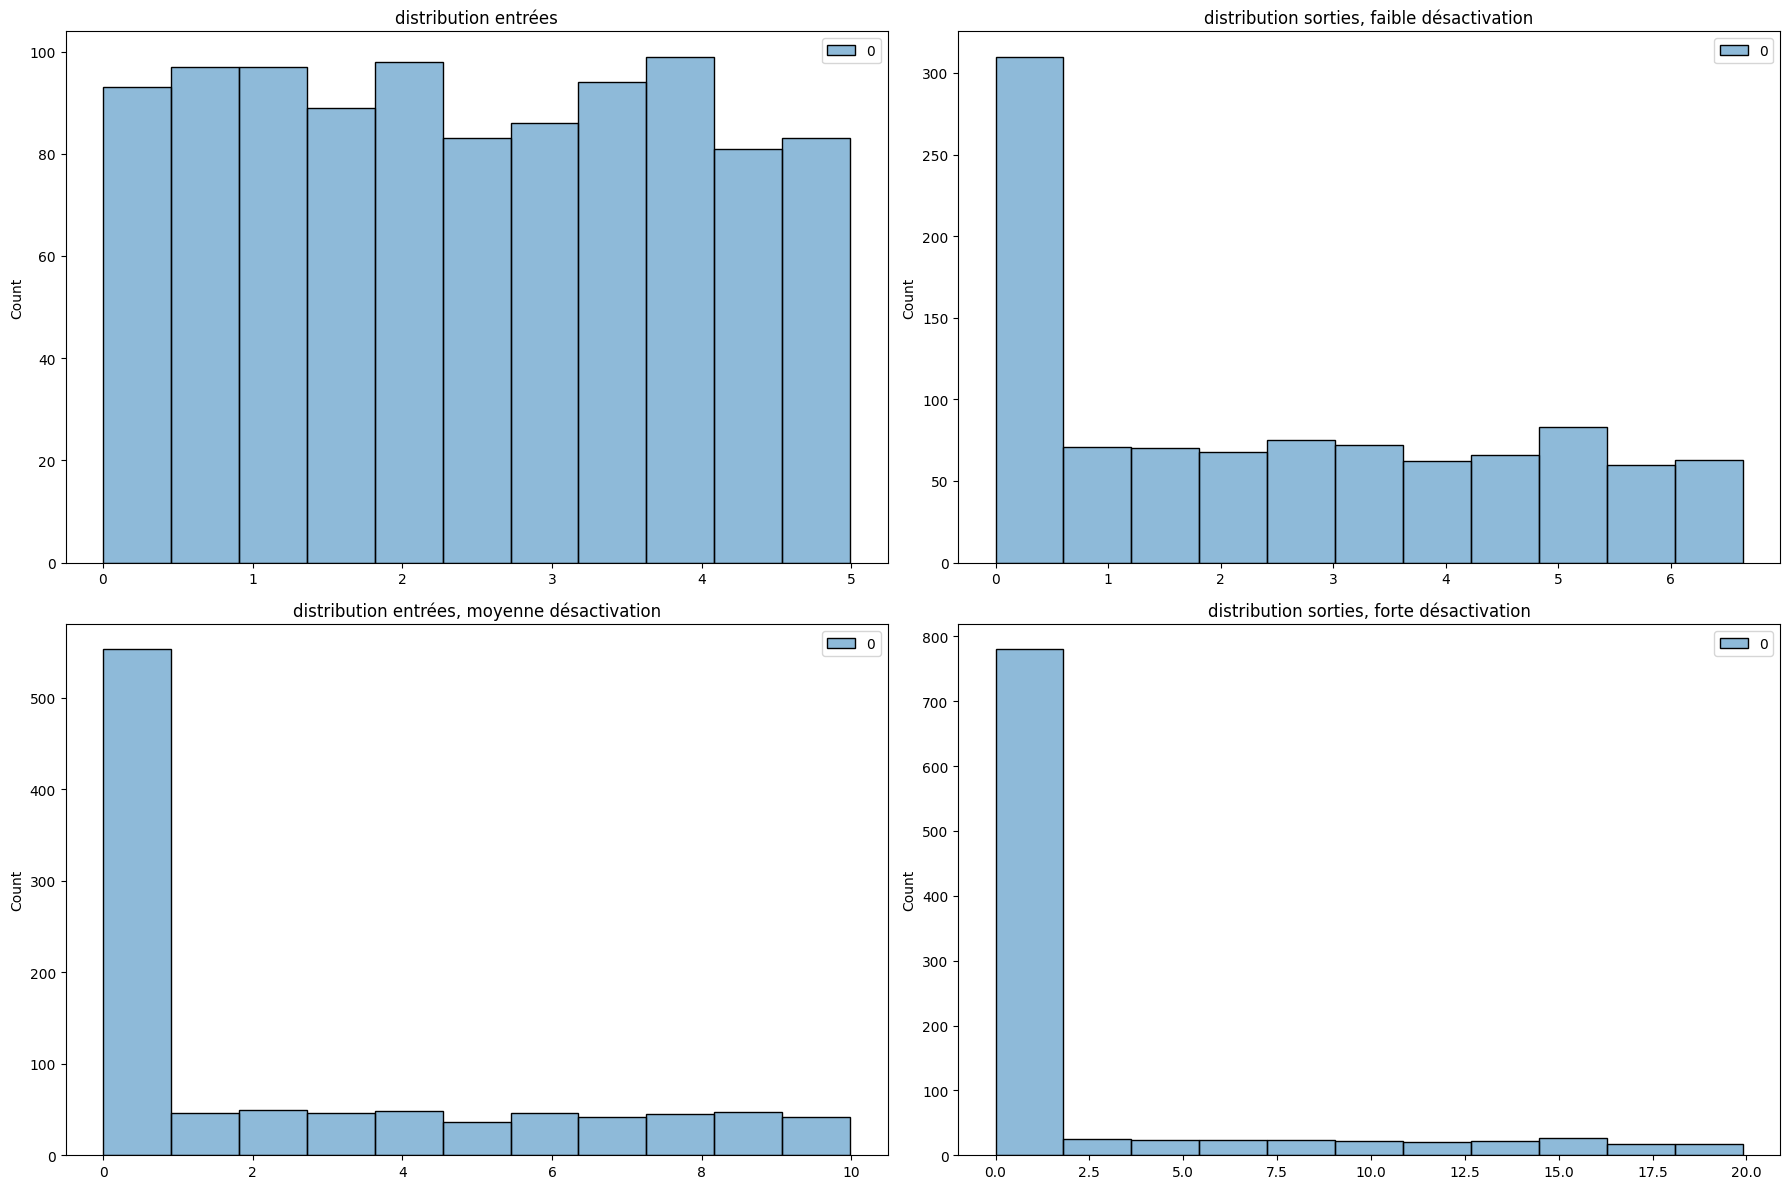

In [170]:
plt.figure(figsize=(18, 12))

plt.subplot(221)
sns.histplot(x.detach().numpy())
plt.title("distribution entrées")

plt.subplot(222)
sns.histplot(y_s.detach().numpy())
plt.title("distribution sorties, faible désactivation")

plt.subplot(223)
sns.histplot(y_m.detach().numpy())
plt.title("distribution entrées, moyenne désactivation")

plt.subplot(224)
sns.histplot(y_l.detach().numpy())
plt.title("distribution sorties, forte désactivation")

plt.tight_layout()
plt.show()

In [171]:
def manual_dropout(input, p=0.25):
    """
    désactivation neurones avec proba p
    conservation espérance
    """
    mask = (torch.rand_like(input) > p).float()
    output = input * mask / (1 - p)

    return output

In [172]:
y_manual_s, y_manual_m, y_manual_l = manual_dropout(x), manual_dropout(x, 0.5), manual_dropout(x, 0.75)

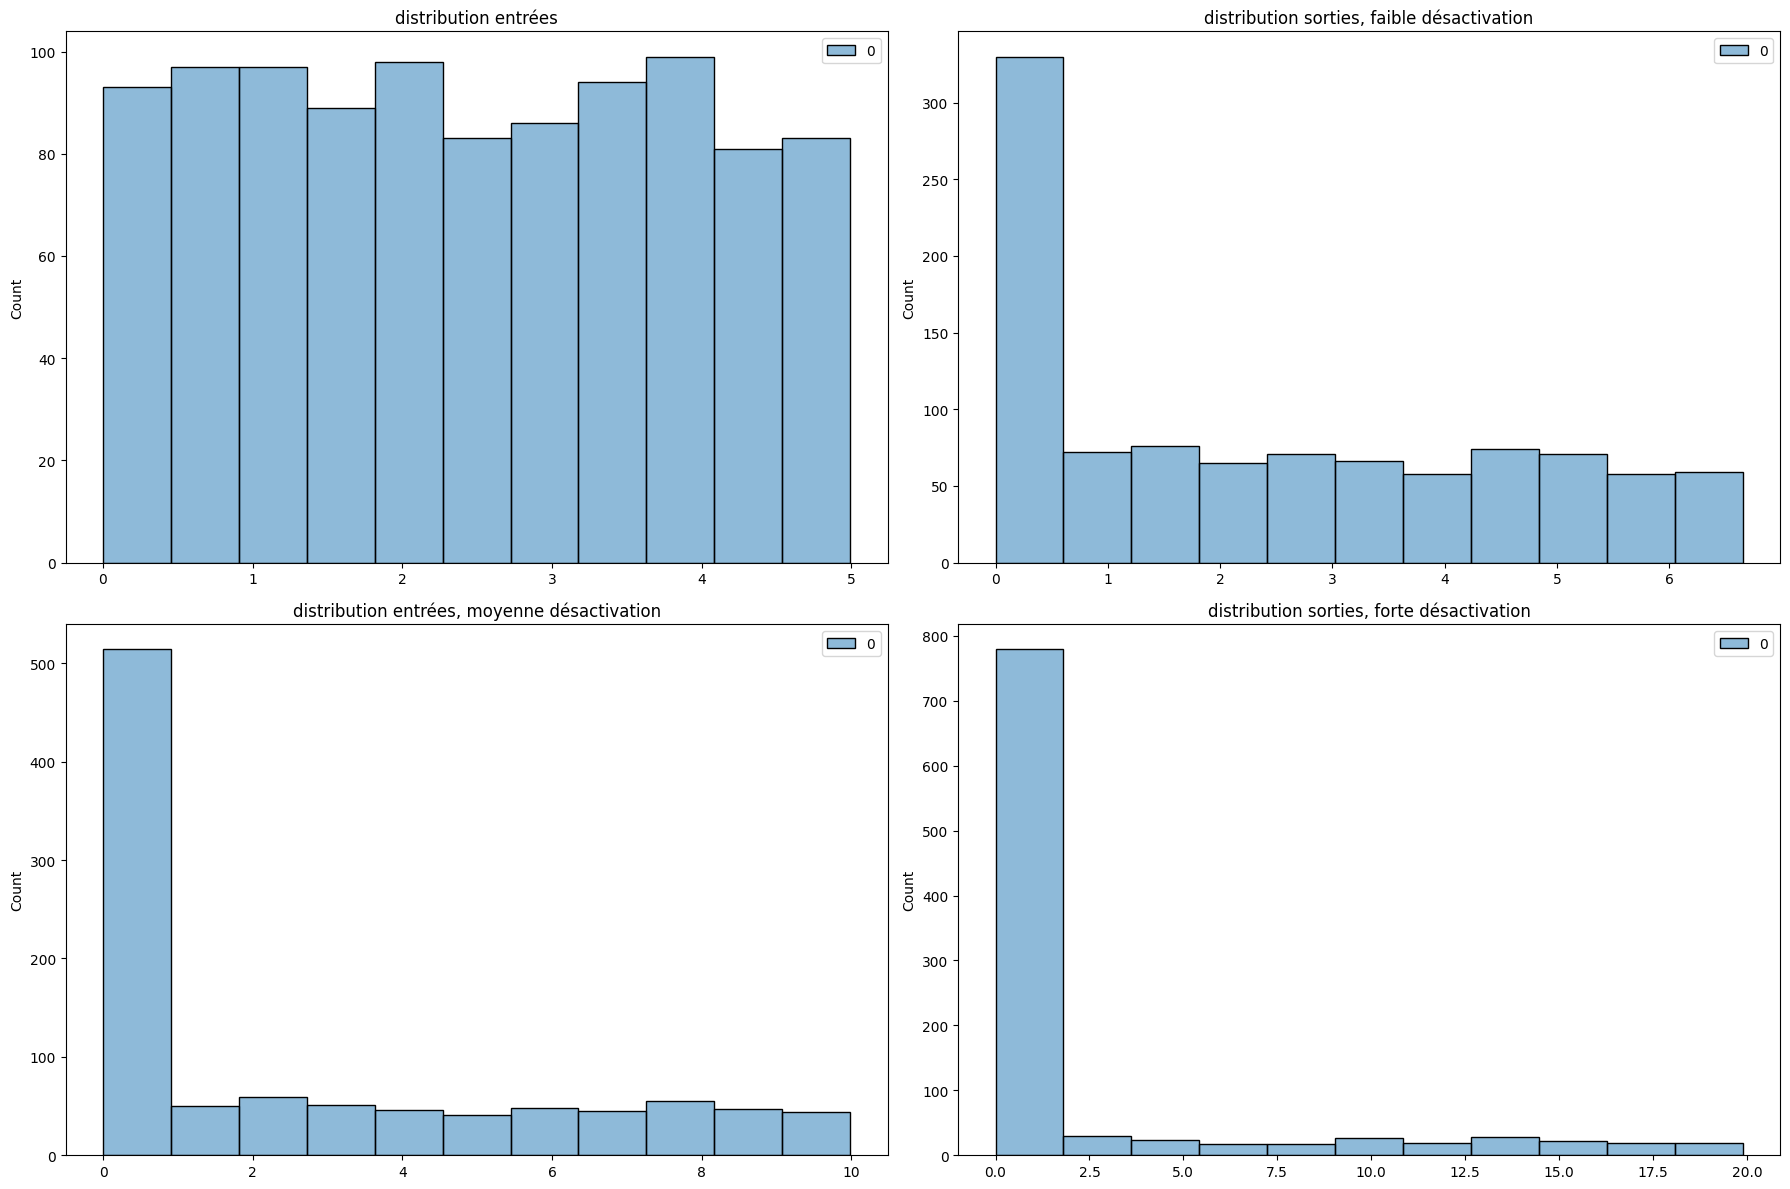

In [173]:
plt.figure(figsize=(18, 12))

plt.subplot(221)
sns.histplot(x.detach().numpy())
plt.title("distribution entrées")

plt.subplot(222)
sns.histplot(y_manual_s.detach().numpy())
plt.title("distribution sorties, faible désactivation")

plt.subplot(223)
sns.histplot(y_manual_m.detach().numpy())
plt.title("distribution entrées, moyenne désactivation")

plt.subplot(224)
sns.histplot(y_manual_l.detach().numpy())
plt.title("distribution sorties, forte désactivation")

plt.tight_layout()
plt.show()

#### **MaxPool**
---

In [183]:
x = output_manual[0]
pool_layer = nn.MaxPool2d(2, 1)

print(x.shape, '\n', x[:5, :5])

torch.Size([12, 12]) 
 tensor([[-0.2086, -0.2216, -0.2332, -0.1426, -0.2444],
        [-0.1282, -0.1033, -0.1929, -0.1731, -0.1631],
        [-0.2071, -0.2584, -0.2940, -0.1611, -0.2534],
        [-0.2050, -0.1108, -0.2191, -0.2481, -0.2239],
        [-0.1514, -0.1907, -0.1568, -0.1969, -0.0977]])


In [184]:
print(pool_layer(x.unsqueeze(0)).shape, '\n', pool_layer(x.unsqueeze(0))[0, :4, :4])

torch.Size([1, 11, 11]) 
 tensor([[-0.1033, -0.1033, -0.1426, -0.1426],
        [-0.1033, -0.1033, -0.1611, -0.1611],
        [-0.1108, -0.1108, -0.1611, -0.1611],
        [-0.1108, -0.1108, -0.1568, -0.0977]])


#### **AvgPool**
---

In [185]:
avg_layer = nn.AvgPool2d(3, 1)
print(avg_layer(x.unsqueeze(0)).shape, '\n', avg_layer(x.unsqueeze(0))[0, :4, :4])

torch.Size([1, 10, 10]) 
 tensor([[-0.2053, -0.1978, -0.2064, -0.2085],
        [-0.1910, -0.1956, -0.2143, -0.2026],
        [-0.1993, -0.2040, -0.2057, -0.1920],
        [-0.2267, -0.2199, -0.2087, -0.1908]])


#### **Flatten**
---

In [191]:
flat_layer = nn.Flatten()
y = flat_layer(x.unsqueeze(0))
print(y)

tensor([[-0.2086, -0.2216, -0.2332, -0.1426, -0.2444, -0.3681, -0.2833, -0.2191,
         -0.1329, -0.2022, -0.1452, -0.0810, -0.1282, -0.1033, -0.1929, -0.1731,
         -0.1631, -0.2313, -0.2279, -0.1887, -0.1404, -0.2504, -0.2383, -0.1824,
         -0.2071, -0.2584, -0.2940, -0.1611, -0.2534, -0.1395, -0.1452, -0.2129,
         -0.1062, -0.2616, -0.2126, -0.0986, -0.2050, -0.1108, -0.2191, -0.2481,
         -0.2239, -0.2301, -0.1509, -0.2752, -0.1644, -0.2450, -0.1208, -0.0969,
         -0.1514, -0.1907, -0.1568, -0.1969, -0.0977, -0.1776, -0.2797, -0.3478,
         -0.1787, -0.2989, -0.1042, -0.0445, -0.3079, -0.3702, -0.3282, -0.1578,
         -0.2494, -0.1354, -0.0621, -0.2075, -0.0818, -0.1030, -0.1137, -0.0750,
         -0.2238, -0.2632, -0.1713, -0.1431, -0.1070, -0.1121, -0.0076, -0.1206,
         -0.0742, -0.0838, -0.2991, -0.0465, -0.2816, -0.3459, -0.2192, -0.1431,
         -0.2881, -0.1326, -0.2316, -0.3728, -0.2549, -0.1103, -0.1680, -0.0236,
         -0.3040, -0.1362, -

#### **Embedding**
---

In [ ]:
# encodage variables catégoriques
values_number = 16 # nombre de catégories ?
encodded_dim = 4 # dimension d'encodage

x = torch.randint(0, 16, (250, 2))

embbed_layer = nn.Embedding(values_number, encodded_dim)
y = embbed_layer(x)

In [197]:
print(x.shape, y.shape)
print(x[:10, 0])
print(y[:10, 0, :])

torch.Size([250, 2]) torch.Size([250, 2, 4])
tensor([15,  6,  5, 13, 13, 12, 10,  4, 11,  5])
tensor([[ 0.0819,  0.9226, -0.8611,  0.5072],
        [ 1.1538,  0.3117, -0.9498, -1.8274],
        [-0.2289, -0.5166, -0.2083, -0.4064],
        [-0.3493, -0.3946,  0.2496,  0.6131],
        [-0.3493, -0.3946,  0.2496,  0.6131],
        [ 0.1740,  0.3277,  0.6255, -0.6561],
        [-0.2873, -2.8376, -0.0885, -0.8188],
        [ 0.7984, -0.9111,  0.0664,  0.7888],
        [ 0.3335,  0.8813,  2.0559,  2.1426],
        [-0.2289, -0.5166, -0.2083, -0.4064]], grad_fn=<SliceBackward0>)


In [199]:
for param in embbed_layer.parameters():
    print(param.shape, '\n', param)

torch.Size([16, 4]) 
 Parameter containing:
tensor([[-0.2630,  0.6333,  0.0423,  0.0838],
        [-0.0543, -0.4884, -0.6207,  1.3899],
        [-0.3701, -1.1520, -1.4202, -0.2129],
        [-2.0041,  0.5732, -0.7276, -1.1774],
        [ 0.7984, -0.9111,  0.0664,  0.7888],
        [-0.2289, -0.5166, -0.2083, -0.4064],
        [ 1.1538,  0.3117, -0.9498, -1.8274],
        [-1.0130,  0.2767, -0.3593,  1.0888],
        [-0.6724,  0.0140, -3.5644,  0.4023],
        [-0.1703,  0.4252,  0.7218,  0.4650],
        [-0.2873, -2.8376, -0.0885, -0.8188],
        [ 0.3335,  0.8813,  2.0559,  2.1426],
        [ 0.1740,  0.3277,  0.6255, -0.6561],
        [-0.3493, -0.3946,  0.2496,  0.6131],
        [ 0.5046, -0.3316,  0.8539, -0.5236],
        [ 0.0819,  0.9226, -0.8611,  0.5072]], requires_grad=True)
